# IA-AirBnB ? Notebook interactif

Objectif: predire le prix Airbnb a partir des donnees de Lyon et Paris.
Chaque bloc ci-dessous affiche ses resultats directement sous la cellule.


## 1) Imports (a executer en premier)


In [21]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score


In [22]:
%matplotlib inline
# Afficher les figures directement dans le notebook


## 2) Parametres et colonnes utiles


In [23]:
DATA_LYON_PATH = "listingsLyon.csv"
DATA_PARIS_PATH = "listingsParis.csv"
OUTPUT_DIR = "outputs"
FIG_DIR = os.path.join(OUTPUT_DIR, "figures")

RELEVANT_COLUMNS = [
    "price",
    "latitude",
    "longitude",
    "neighbourhood_cleansed",
    "property_type",
    "room_type",
    "accommodates",
    "bathrooms_text",
    "bedrooms",
    "beds",
    "has_availability",
    "availability_30",
    "availability_60",
    "availability_90",
    "availability_365",
    "minimum_nights",
    "maximum_nights",
    "number_of_reviews",
    "reviews_per_month",
    "review_scores_rating",
    "review_scores_accuracy",
    "review_scores_cleanliness",
    "review_scores_checkin",
    "review_scores_communication",
    "review_scores_location",
    "review_scores_value",
    "instant_bookable",
    "host_is_superhost",
]

NUMERIC_COERCE_COLUMNS = [
    "price",
    "bathrooms_text",
    "bedrooms",
    "beds",
    "accommodates",
    "minimum_nights",
    "maximum_nights",
    "availability_30",
    "availability_60",
    "availability_90",
    "availability_365",
    "number_of_reviews",
    "reviews_per_month",
    "review_scores_rating",
    "review_scores_accuracy",
    "review_scores_cleanliness",
    "review_scores_checkin",
    "review_scores_communication",
    "review_scores_location",
    "review_scores_value",
]

CATEGORICAL_COLUMNS = [
    "neighbourhood_cleansed",
    "property_type",
    "room_type",
]


## 3) Fonctions (pretraitement + sauvegarde + modeles)


In [24]:
def ensure_dirs():
    os.makedirs(FIG_DIR, exist_ok=True)


def load_data():
    lyon = pd.read_csv(DATA_LYON_PATH)
    paris = pd.read_csv(DATA_PARIS_PATH)

    print("=== Chargement des donnees ===")
    print(f"Dimensions Lyon: {lyon.shape}")
    print(f"Dimensions Paris: {paris.shape}")
    print(f"Memes colonnes: {list(lyon.columns) == list(paris.columns)}")
    print("====================\n")
    return lyon, paris


def select_columns(df: pd.DataFrame) -> pd.DataFrame:
    cols = [col for col in RELEVANT_COLUMNS if col in df.columns]
    return df[cols].copy()


def drop_duplicates(df: pd.DataFrame, label: str) -> pd.DataFrame:
    dup_count = df.duplicated().sum()
    print(f"{label}: doublons avant suppression = {dup_count}")
    return df.drop_duplicates()


def convert_types(df: pd.DataFrame) -> pd.DataFrame:
    if "price" in df.columns:
        df["price"] = pd.to_numeric(
            df["price"].replace(r"[^0-9.]", "", regex=True), errors="coerce"
        )
    if "bathrooms_text" in df.columns:
        df["bathrooms_text"] = pd.to_numeric(
            df["bathrooms_text"].astype(str).str.extract(r"([0-9]*\.?[0-9]+)")[0],
            errors="coerce",
        )
    for col in NUMERIC_COERCE_COLUMNS:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")
    for col in ["has_availability", "instant_bookable", "host_is_superhost"]:
        if col in df.columns:
            df[col] = df[col].map({"t": 1, "f": 0})
    return df


def fill_missing_values(df: pd.DataFrame) -> pd.DataFrame:
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())
    categorical_cols = df.select_dtypes(include=["object"]).columns
    if len(categorical_cols) > 0:
        df[categorical_cols] = df[categorical_cols].fillna("Inconnu")
    if "bathrooms_text" in df.columns:
        df["bathrooms_text"] = np.ceil(df["bathrooms_text"]).astype(int)
    return df


def recode_rare_categories(df: pd.DataFrame, column: str, min_freq: float = 0.01) -> pd.DataFrame:
    if column in df.columns:
        freq = df[column].value_counts(normalize=True)
        rare = freq[freq < min_freq].index
        df[column] = df[column].where(~df[column].isin(rare), other="Autre")
    return df


def preprocess(df: pd.DataFrame, label: str) -> pd.DataFrame:
    df = select_columns(df)
    df = drop_duplicates(df, label)
    df = convert_types(df)
    df = fill_missing_values(df)
    df = recode_rare_categories(df, "property_type", min_freq=0.01)
    df = recode_rare_categories(df, "neighbourhood_cleansed", min_freq=0.01)
    return df


def save_figure(fig, filename: str):
    path = os.path.join(FIG_DIR, filename)
    fig.savefig(path, dpi=150, bbox_inches="tight")
    display(fig)
    plt.close(fig)
    print(f"Figure enregistree: {path}")


def train_test_split_data(df: pd.DataFrame, features: list, target: str = "price"):
    X = df[features]
    y = df[target]
    return train_test_split(X, y, test_size=0.4, random_state=42)


def linear_regression_simple(df: pd.DataFrame, label: str):
    X_train, X_test, y_train, y_test = train_test_split_data(df, ["accommodates"])
    model = LinearRegression()
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    r2 = r2_score(y_test, preds)
    print(f"{label} - Regression lineaire simple R2: {r2:.4f}")

    fig, ax = plt.subplots(figsize=(6, 4))
    ax.scatter(X_test["accommodates"], y_test, alpha=0.4, label="Reel")
    x_line = np.linspace(df["accommodates"].min(), df["accommodates"].max(), 100)
    x_line_df = pd.DataFrame({"accommodates": x_line})
    y_line = model.predict(x_line_df)
    ax.plot(x_line, y_line, color="red", label="Droite de regression")
    ax.set_title(f"{label} - Regression lineaire simple")
    ax.set_xlabel("Accommodates")
    ax.set_ylabel("Prix")
    ax.legend()
    save_figure(fig, f"simple_regression_{label.lower()}.png")


def linear_regression_multiple(df: pd.DataFrame, label: str):
    feature_cols = [
        "accommodates",
        "bathrooms_text",
        "bedrooms",
        "beds",
        "latitude",
        "longitude",
        "minimum_nights",
        "maximum_nights",
        "availability_365",
        "number_of_reviews",
        "review_scores_rating",
        "instant_bookable",
        "host_is_superhost",
        "room_type",
        "property_type",
        "neighbourhood_cleansed",
    ]
    feature_cols = [col for col in feature_cols if col in df.columns]
    model_df = df[feature_cols + ["price"]].copy()
    cat_cols = [col for col in CATEGORICAL_COLUMNS if col in model_df.columns]
    model_df = pd.get_dummies(model_df, columns=cat_cols, drop_first=True)

    X = model_df.drop(columns=["price"])
    y = model_df["price"]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.4, random_state=42
    )

    model = LinearRegression()
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    r2 = r2_score(y_test, preds)
    print(f"{label} - Regression lineaire multiple R2: {r2:.4f}")

    fig, ax = plt.subplots(figsize=(6, 4))
    ax.scatter(y_test, preds, alpha=0.4)
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")
    ax.set_title(f"{label} - Regression multiple (Reel vs predit)")
    ax.set_xlabel("Prix reel")
    ax.set_ylabel("Prix predit")
    save_figure(fig, f"multiple_regression_{label.lower()}.png")


## 4) Chargement et pretraitement (sorties sous chaque bloc)


In [25]:
ensure_dirs()
lyon_raw, paris_raw = load_data()


=== Chargement des donnees ===
Dimensions Lyon: (9691, 79)
Dimensions Paris: (84055, 79)
Memes colonnes: True



In [26]:
lyon = preprocess(lyon_raw, "Lyon")
paris = preprocess(paris_raw, "Paris")


Lyon: doublons avant suppression = 2
Paris: doublons avant suppression = 45


## 5) Analyse descriptive (1 graphique = 1 bloc)


### 5.1 Note vs prix (Lyon/Paris)


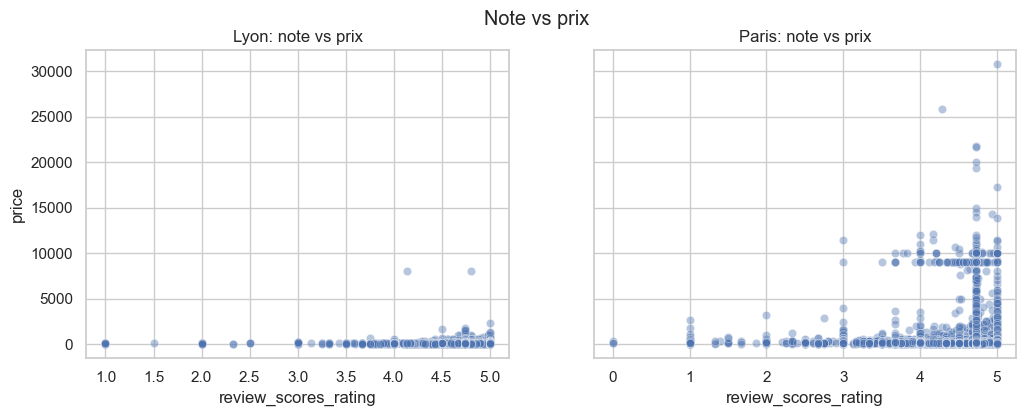

Figure enregistree: outputs\figures\rating_vs_price.png


In [27]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
sns.scatterplot(data=lyon, x="review_scores_rating", y="price", alpha=0.4, ax=axes[0])
axes[0].set_title("Lyon: note vs prix")
sns.scatterplot(data=paris, x="review_scores_rating", y="price", alpha=0.4, ax=axes[1])
axes[1].set_title("Paris: note vs prix")
fig.suptitle("Note vs prix")
save_figure(fig, "rating_vs_price.png")


### 5.2 Prix moyen par type de propriete


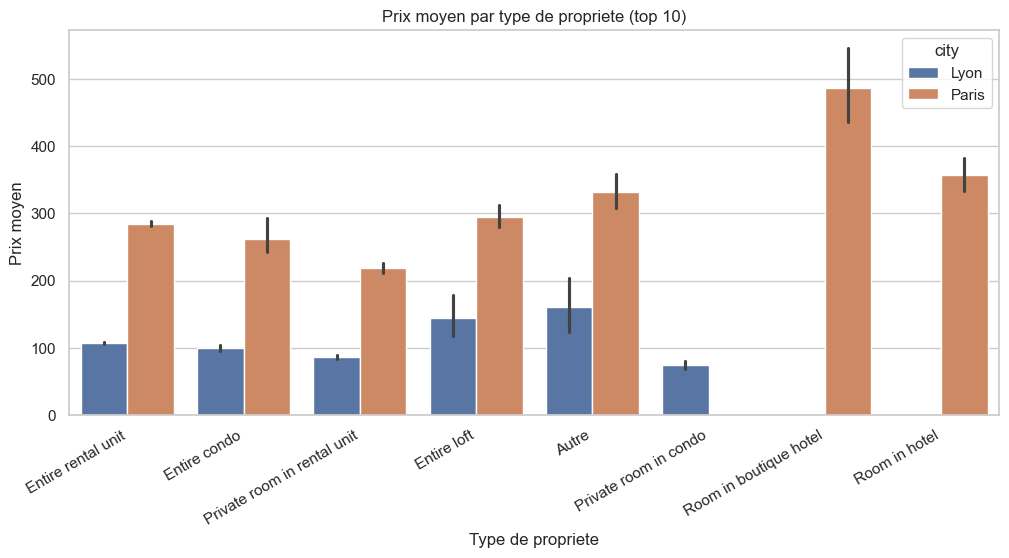

Figure enregistree: outputs\figures\mean_price_by_property_type.png


In [28]:
combined = pd.concat([lyon.assign(city="Lyon"), paris.assign(city="Paris")], ignore_index=True)
top_props = combined["property_type"].value_counts().head(10).index
fig, ax = plt.subplots(figsize=(12, 5))
sns.barplot(data=combined[combined["property_type"].isin(top_props)], x="property_type", y="price", hue="city", ax=ax)
ax.set_title("Prix moyen par type de propriete (top 10)")
ax.set_xlabel("Type de propriete")
ax.set_ylabel("Prix moyen")
plt.xticks(rotation=30, ha="right")
save_figure(fig, "mean_price_by_property_type.png")


### 5.3 Disponibilite vs prix


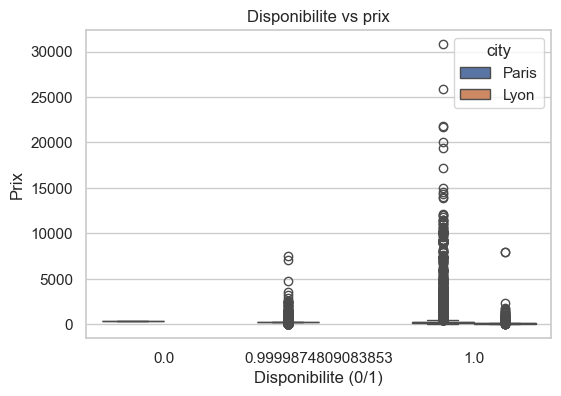

Figure enregistree: outputs\figures\availability_vs_price.png


In [29]:
combined = pd.concat([lyon.assign(city="Lyon"), paris.assign(city="Paris")], ignore_index=True)
fig, ax = plt.subplots(figsize=(6, 4))
sns.boxplot(data=combined, x="has_availability", y="price", hue="city", ax=ax)
ax.set_title("Disponibilite vs prix")
ax.set_xlabel("Disponibilite (0/1)")
ax.set_ylabel("Prix")
save_figure(fig, "availability_vs_price.png")


### 5.4 Repartition des logements disponibles


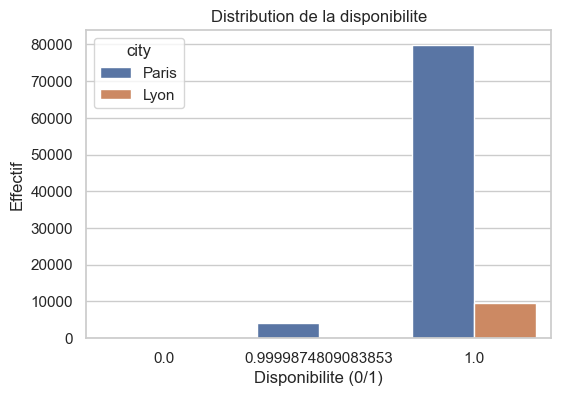

Figure enregistree: outputs\figures\availability_distribution.png


In [30]:
combined = pd.concat([lyon.assign(city="Lyon"), paris.assign(city="Paris")], ignore_index=True)
fig, ax = plt.subplots(figsize=(6, 4))
sns.countplot(data=combined, x="has_availability", hue="city", ax=ax)
ax.set_title("Distribution de la disponibilite")
ax.set_xlabel("Disponibilite (0/1)")
ax.set_ylabel("Effectif")
save_figure(fig, "availability_distribution.png")


### 5.5 Distribution des prix par type de chambre


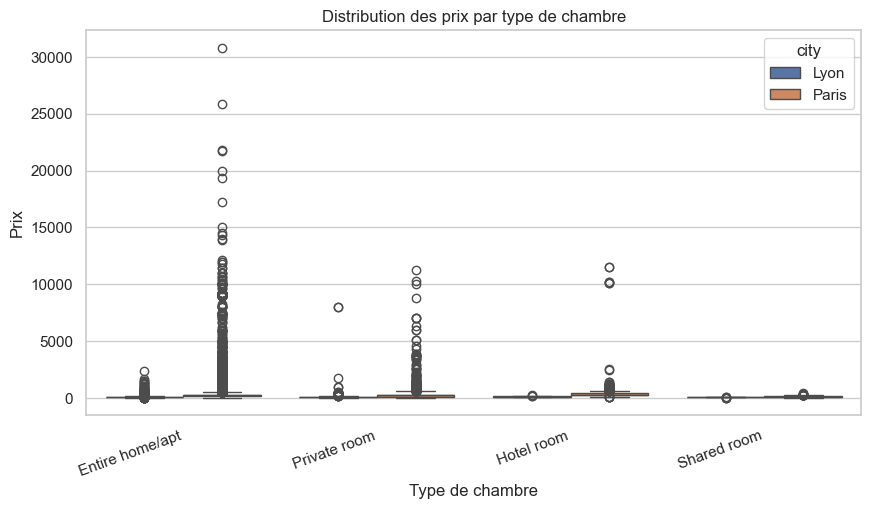

Figure enregistree: outputs\figures\price_by_room_type.png


In [31]:
combined = pd.concat([lyon.assign(city="Lyon"), paris.assign(city="Paris")], ignore_index=True)
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=combined, x="room_type", y="price", hue="city", ax=ax)
ax.set_title("Distribution des prix par type de chambre")
ax.set_xlabel("Type de chambre")
ax.set_ylabel("Prix")
plt.xticks(rotation=20, ha="right")
save_figure(fig, "price_by_room_type.png")


## 6) Valeurs aberrantes + normalisation


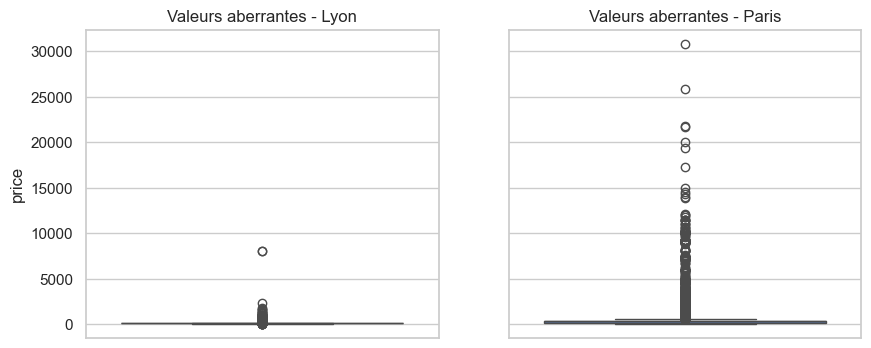

Figure enregistree: outputs\figures\price_outliers_boxplot.png


In [32]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
sns.boxplot(y=lyon["price"], ax=axes[0])
axes[0].set_title("Valeurs aberrantes - Lyon")
sns.boxplot(y=paris["price"], ax=axes[1])
axes[1].set_title("Valeurs aberrantes - Paris")
save_figure(fig, "price_outliers_boxplot.png")


In [33]:
scaler_lyon = MinMaxScaler()
scaler_paris = MinMaxScaler()
lyon["price_scaled"] = scaler_lyon.fit_transform(lyon[["price"]])
paris["price_scaled"] = scaler_paris.fit_transform(paris[["price"]])

lyon[["price", "price_scaled"]].head()


,price,price_scaled
0,121.0,0.013275
1,90.0,0.009393
2,83.0,0.008516
3,88.0,0.009142
4,189.0,0.021791


## 7) Modelisation (1 bloc = 1 modele)


### 7.1 Regression simple ? Lyon


Lyon - Regression lineaire simple R2: 0.0497


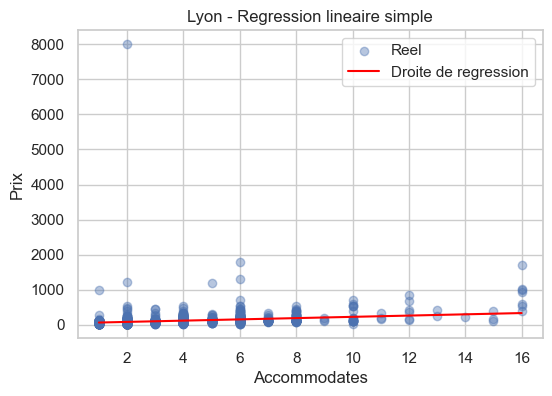

Figure enregistree: outputs\figures\simple_regression_lyon.png


In [34]:
linear_regression_simple(lyon, "Lyon")


### 7.2 Regression multiple ? Lyon


Lyon - Regression lineaire multiple R2: 0.0740


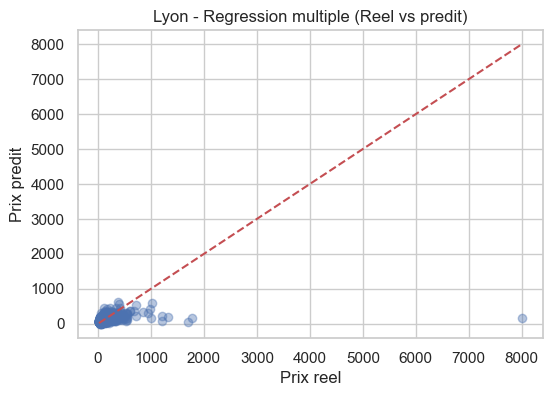

Figure enregistree: outputs\figures\multiple_regression_lyon.png


In [35]:
linear_regression_multiple(lyon, "Lyon")


### 7.3 Regression simple ? Paris


Paris - Regression lineaire simple R2: 0.0438


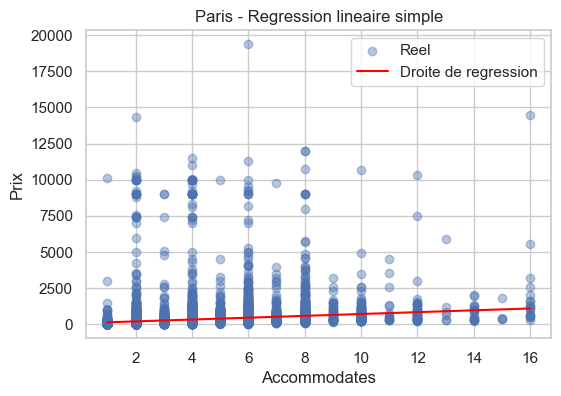

Figure enregistree: outputs\figures\simple_regression_paris.png


In [36]:
linear_regression_simple(paris, "Paris")


### 7.4 Regression multiple ? Paris


Paris - Regression lineaire multiple R2: 0.0739


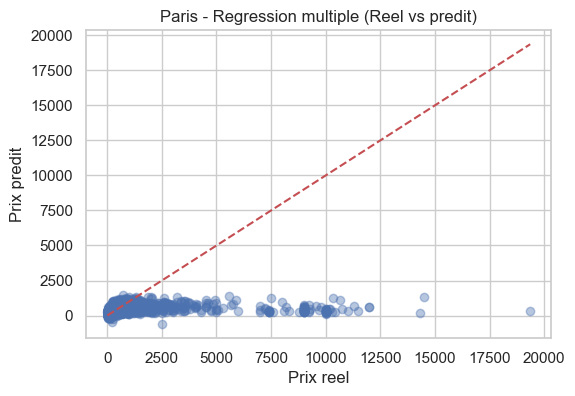

Figure enregistree: outputs\figures\multiple_regression_paris.png


In [37]:
linear_regression_multiple(paris, "Paris")
